# SET Card Classifier - Development Notebook

This notebook trains a CNN classifier for SET card properties using real card images.

Unlike playing cards which have 53 classes (single classification), SET cards have 4 independent properties:
- **Shape**: diamond, oval, squiggle (3 classes)
- **Color**: red, green, purple (3 classes)
- **Number**: 1, 2, 3 (3 classes)
- **Shading**: solid, striped, empty (3 classes)

This gives 3×3×3×3 = 81 unique cards. We use a multi-head CNN architecture.

## Setup Dependencies

In [1]:
# Install required packages
%pip install -U matplotlib pandas scikit-learn torch torchvision tqdm

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import sys
import copy
from pathlib import Path
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

System Version: 3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.0.13.3)]
PyTorch version: 2.9.1
Torchvision version: 0.24.1
Numpy version: 2.4.0
Pandas version: 2.3.3


## Define SET Card Constants

In [3]:
# SET Card Properties
SHAPES = ('diamond', 'oval', 'squiggle')
COLORS = ('red', 'green', 'purple')
NUMBERS = (1, 2, 3)
SHADINGS = ('solid', 'striped', 'empty')

# Index mappings for classification
SHAPE_TO_IDX = {s: i for i, s in enumerate(SHAPES)}
COLOR_TO_IDX = {c: i for i, c in enumerate(COLORS)}
NUMBER_TO_IDX = {n: i for i, n in enumerate(NUMBERS)}
SHADING_TO_IDX = {s: i for i, s in enumerate(SHADINGS)}

IDX_TO_SHAPE = {i: s for s, i in SHAPE_TO_IDX.items()}
IDX_TO_COLOR = {i: c for c, i in COLOR_TO_IDX.items()}
IDX_TO_NUMBER = {i: n for n, i in NUMBER_TO_IDX.items()}
IDX_TO_SHADING = {i: s for s, i in SHADING_TO_IDX.items()}

print(f"Shapes: {SHAPE_TO_IDX}")
print(f"Colors: {COLOR_TO_IDX}")
print(f"Numbers: {NUMBER_TO_IDX}")
print(f"Shadings: {SHADING_TO_IDX}")
print(f"\nTotal unique cards: {len(SHAPES) * len(COLORS) * len(NUMBERS) * len(SHADINGS)}")

Shapes: {'diamond': 0, 'oval': 1, 'squiggle': 2}
Colors: {'red': 0, 'green': 1, 'purple': 2}
Numbers: {1: 0, 2: 1, 3: 2}
Shadings: {'solid': 0, 'striped': 1, 'empty': 2}

Total unique cards: 81


## Set up the Dataset

### SET Card Dataset Class

A custom dataset class for handling SET card images. Unlike the playing card classifier which uses a single label,
our dataset returns 4 separate labels (one for each property).

Directory structure expected: `cards/{number}_{shape}_{shading}_{color}/*.jpg`

In [4]:
class SetCardDataset(Dataset):
    """Dataset for SET card classification."""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []
        
        # Collect all samples from directory structure
        for card_dir in self.data_dir.iterdir():
            if card_dir.is_dir():
                # Parse card properties from directory name: {number}_{shape}_{shading}_{color}
                parts = card_dir.name.split('_')
                if len(parts) == 4:
                    number, shape, shading, color = parts
                    labels = {
                        'shape': SHAPE_TO_IDX[shape],
                        'color': COLOR_TO_IDX[color],
                        'number': NUMBER_TO_IDX[int(number)],
                        'shading': SHADING_TO_IDX[shading],
                    }
                    
                    for img_path in card_dir.glob('*.jpg'):
                        self.samples.append((img_path, labels))
        
        print(f"Loaded {len(self.samples)} samples from {self.data_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, labels = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels
    
    @property
    def classes(self):
        """Return unique card type names."""
        return list(set(s[0].parent.name for s in self.samples))

### Testing the Dataset

In [5]:
# Load dataset without transforms to visualize
data_dir = './data'
dataset = SetCardDataset(data_dir)
print(f"Dataset size: {len(dataset)}")
print(f"Unique card types: {len(dataset.classes)}")

Loaded 172 samples from ./data
Dataset size: 172
Unique card types: 78


In [6]:
# Test getting an item
image, labels = dataset[0]
print(f"Image size: {image.size}")
print(f"Labels: {labels}")
print(f"\nDecoded labels:")
print(f"  Shape: {IDX_TO_SHAPE[labels['shape']]}")
print(f"  Color: {IDX_TO_COLOR[labels['color']]}")
print(f"  Number: {IDX_TO_NUMBER[labels['number']]}")
print(f"  Shading: {IDX_TO_SHADING[labels['shading']]}")

Image size: (200, 300)
Labels: {'shape': 0, 'color': 1, 'number': 2, 'shading': 0}

Decoded labels:
  Shape: diamond
  Color: green
  Number: 3
  Shading: solid


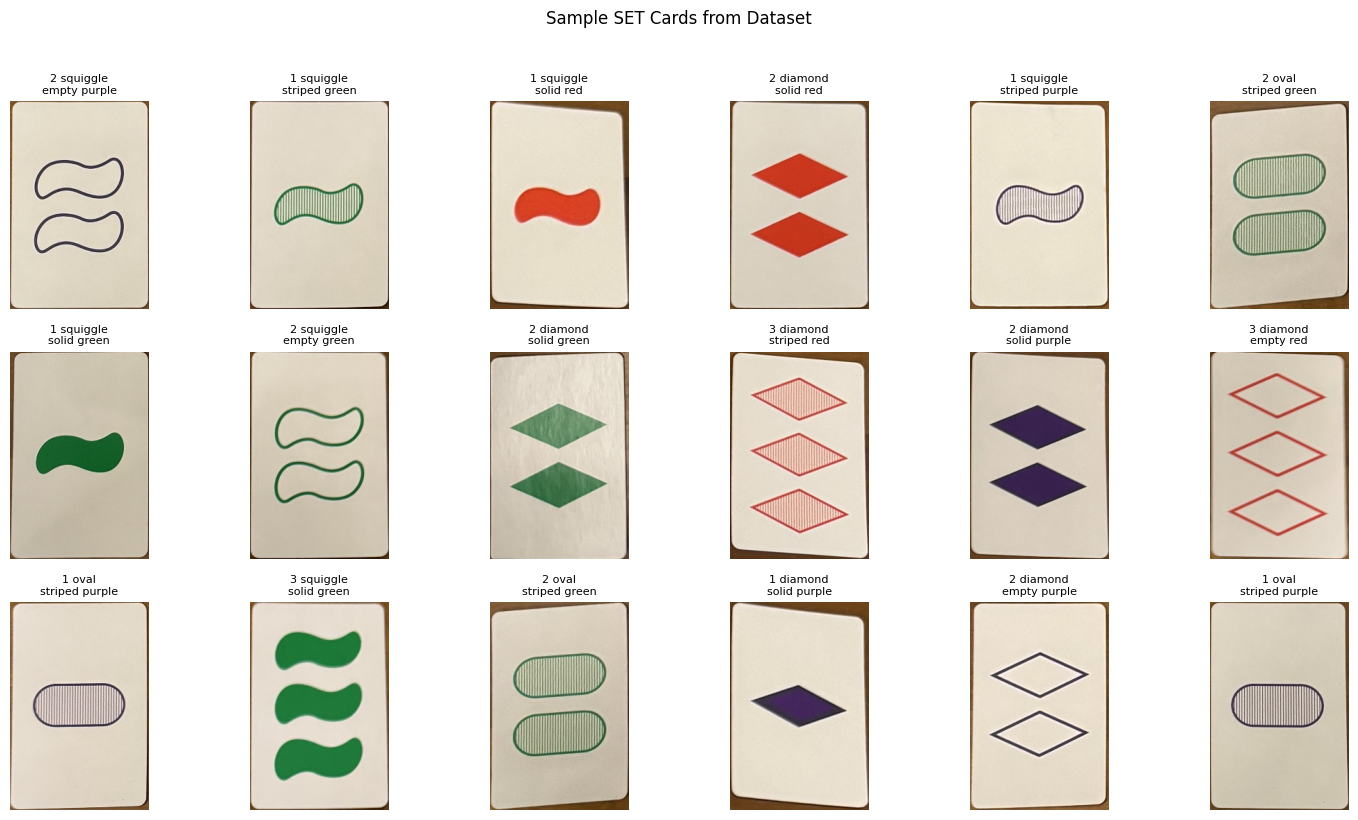

In [7]:
# Visualize sample cards
fig, axes = plt.subplots(3, 6, figsize=(15, 8))
indices = np.random.choice(len(dataset), 18, replace=False)

for ax, idx in zip(axes.flat, indices):
    image, labels = dataset[idx]
    ax.imshow(image)
    ax.axis('off')
    title = f"{IDX_TO_NUMBER[labels['number']]} {IDX_TO_SHAPE[labels['shape']]}\n{IDX_TO_SHADING[labels['shading']]} {IDX_TO_COLOR[labels['color']]}"
    ax.set_title(title, fontsize=8)

plt.suptitle('Sample SET Cards from Dataset', y=1.02)
plt.tight_layout()
plt.show()

### Analyze Dataset Distribution

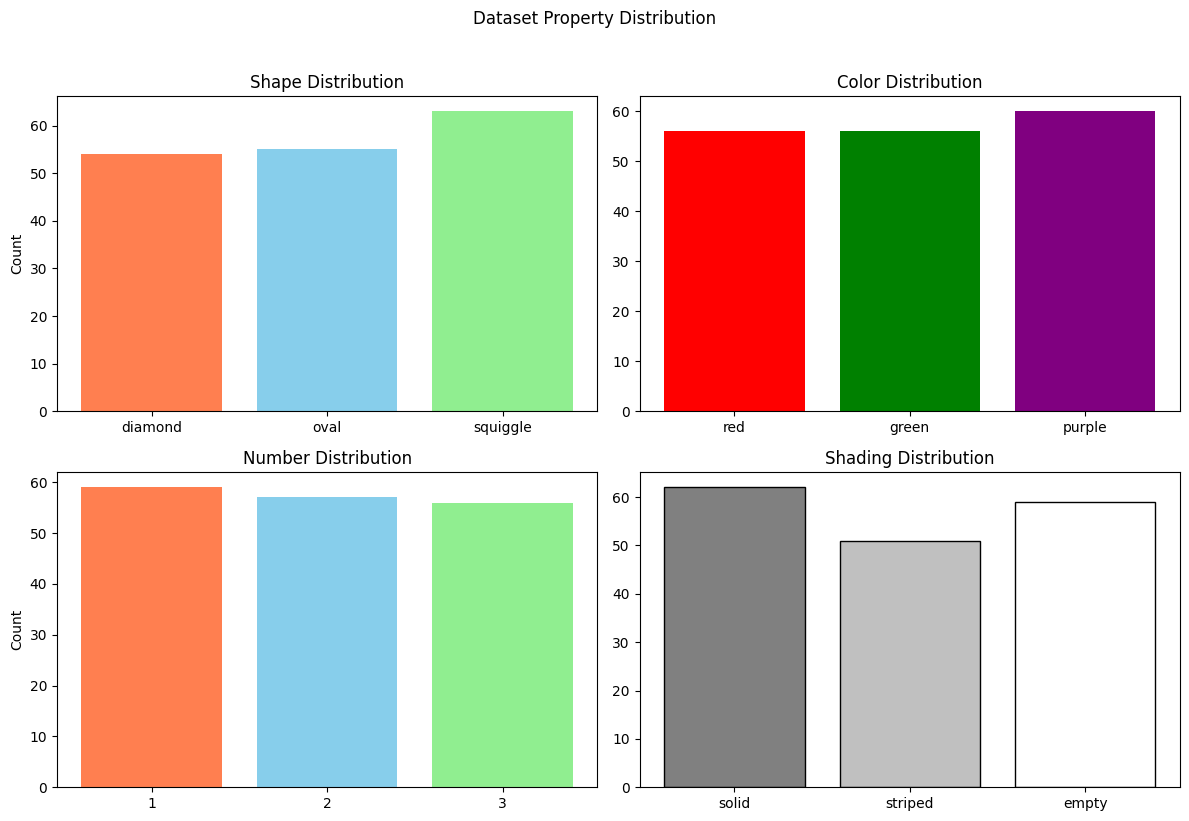


Property counts:
  Shapes: {'diamond': 54, 'oval': 55, 'squiggle': 63}
  Colors: {'red': 56, 'green': 56, 'purple': 60}
  Numbers: {1: 59, 2: 57, 3: 56}
  Shadings: {'solid': 62, 'striped': 51, 'empty': 59}


In [8]:
# Count samples per property value
shape_counts = {s: 0 for s in SHAPES}
color_counts = {c: 0 for c in COLORS}
number_counts = {n: 0 for n in NUMBERS}
shading_counts = {s: 0 for s in SHADINGS}

for _, labels in dataset.samples:
    shape_counts[IDX_TO_SHAPE[labels['shape']]] += 1
    color_counts[IDX_TO_COLOR[labels['color']]] += 1
    number_counts[IDX_TO_NUMBER[labels['number']]] += 1
    shading_counts[IDX_TO_SHADING[labels['shading']]] += 1

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].bar(shape_counts.keys(), shape_counts.values(), color=['coral', 'skyblue', 'lightgreen'])
axes[0, 0].set_title('Shape Distribution')
axes[0, 0].set_ylabel('Count')

axes[0, 1].bar([str(k) for k in color_counts.keys()], color_counts.values(), color=['red', 'green', 'purple'])
axes[0, 1].set_title('Color Distribution')

axes[1, 0].bar([str(k) for k in number_counts.keys()], number_counts.values(), color=['coral', 'skyblue', 'lightgreen'])
axes[1, 0].set_title('Number Distribution')
axes[1, 0].set_ylabel('Count')

axes[1, 1].bar(shading_counts.keys(), shading_counts.values(), color=['gray', 'silver', 'white'], edgecolor='black')
axes[1, 1].set_title('Shading Distribution')

plt.suptitle('Dataset Property Distribution', y=1.02)
plt.tight_layout()
plt.show()

print("\nProperty counts:")
print(f"  Shapes: {dict(shape_counts)}")
print(f"  Colors: {dict(color_counts)}")
print(f"  Numbers: {dict(number_counts)}")
print(f"  Shadings: {dict(shading_counts)}")

### Resize and Transform Images

We apply data augmentation during training to improve generalization, especially with our relatively small dataset.

In [9]:
# Define transforms - CRITICAL: NO RandomCrop (cuts off shapes, breaks number counting!)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Direct resize, NO crop
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5, fill=255),  # Very small rotation
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Training transforms (GENTLE - preserves all shapes for counting):")
print(train_transform)
print("\nValidation transforms:")
print(val_transform)

Training transforms (GENTLE - preserves all shapes for counting):
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=255)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.02, 0.02))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Validation transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Loaded 172 samples from ./data


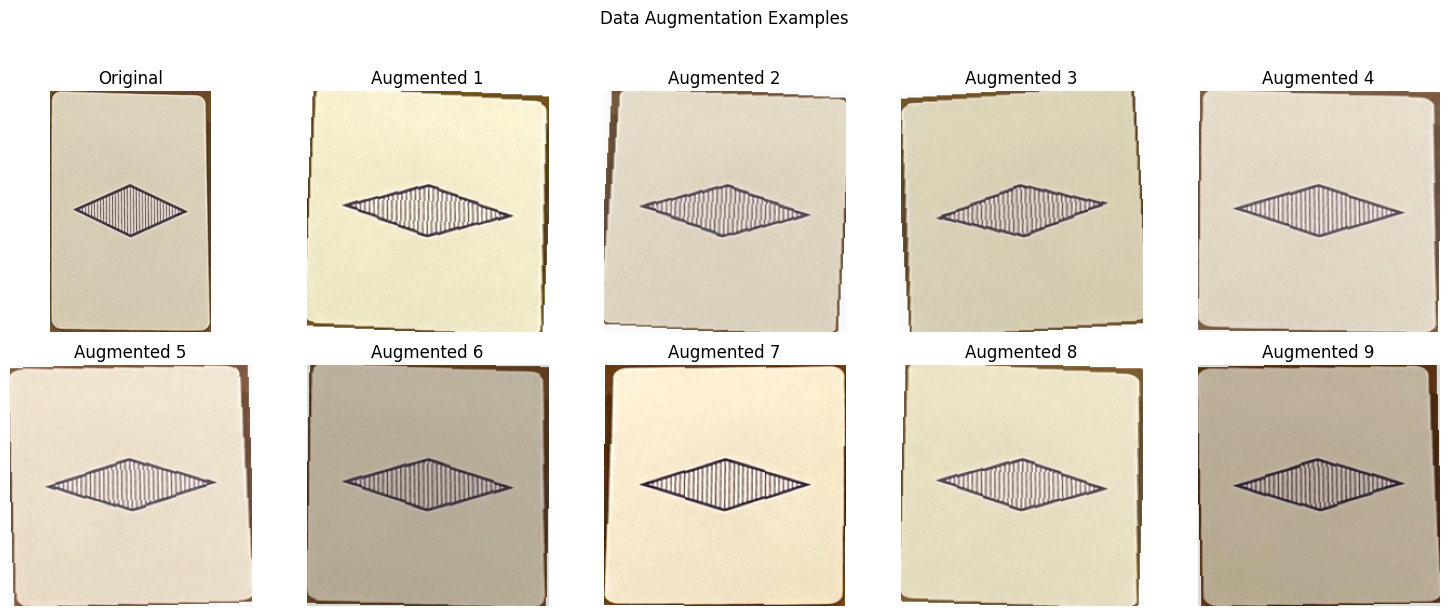

In [10]:
# Visualize augmentation effects
dataset_raw = SetCardDataset(data_dir)
image, labels = dataset_raw[np.random.randint(len(dataset_raw))]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for i in range(1, 10):
    ax = axes[i // 5, i % 5]
    augmented = train_transform(image)
    # Denormalize for visualization
    aug_vis = augmented.numpy().transpose(1, 2, 0)
    aug_vis = aug_vis * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    aug_vis = np.clip(aug_vis, 0, 1)
    ax.imshow(aug_vis)
    ax.set_title(f'Augmented {i}')
    ax.axis('off')

plt.suptitle('Data Augmentation Examples', y=1.02)
plt.tight_layout()
plt.show()

### DataLoader Configuration

In [11]:
def collate_fn(batch):
    """Custom collate function to handle dict labels."""
    images = torch.stack([item[0] for item in batch])
    labels = {
        'shape': torch.tensor([item[1]['shape'] for item in batch]),
        'color': torch.tensor([item[1]['color'] for item in batch]),
        'number': torch.tensor([item[1]['number'] for item in batch]),
        'shading': torch.tensor([item[1]['shading'] for item in batch]),
    }
    return images, labels

# Create train/val split
full_dataset = SetCardDataset(data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, 
    collate_fn=collate_fn, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=16, shuffle=False,
    collate_fn=collate_fn, num_workers=0
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Loaded 172 samples from ./data
Training samples: 137
Validation samples: 35
Training batches: 9
Validation batches: 3


In [12]:
# Test a batch
images, labels = next(iter(train_loader))
print(f"Batch images shape: {images.shape}")
print(f"Batch labels:")
for key, val in labels.items():
    print(f"  {key}: {val.shape} - {val[:5].tolist()}")

Batch images shape: torch.Size([16, 3, 224, 224])
Batch labels:
  shape: torch.Size([16]) - [2, 2, 0, 0, 2]
  color: torch.Size([16]) - [2, 0, 1, 0, 2]
  number: torch.Size([16]) - [1, 1, 2, 1, 0]
  shading: torch.Size([16]) - [1, 1, 2, 0, 1]


## Building the Model

### Multi-Head CNN for SET Card Classification

Unlike playing cards (single 53-class output), we use a **multi-head architecture**:
- Shared CNN backbone (MobileNetV3) extracts features
- 4 separate classification heads predict each property independently

This is more efficient than 81-class classification because:
1. The properties are independent - knowing the color doesn't change the shape
2. Fewer parameters needed (4×3 = 12 outputs vs 81)
3. Better generalization with limited data

In [13]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

class SetCardClassifierCNN(nn.Module):
    """
    Multi-head CNN classifier for SET card properties.
    
    Uses MobileNetV3 as backbone with specialized heads.
    NUMBER head is larger because counting shapes is harder than
    recognizing patterns (shape/color/shading).
    """
    
    def __init__(self, pretrained=True, dropout=0.2):
        super(SetCardClassifierCNN, self).__init__()
        
        # Load pretrained MobileNetV3 backbone
        weights = MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
        self.backbone = mobilenet_v3_small(weights=weights)
        
        # MobileNetV3 Small outputs 576 features
        self.feature_dim = 576
        
        # Remove the original classifier
        self.backbone.classifier = nn.Identity()
        
        # Shared feature processing (larger: 512 instead of 256)
        self.shared_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout / 2),
        )
        
        # Simple heads for easy tasks (pattern recognition)
        self.shape_head = nn.Linear(512, 3)
        self.color_head = nn.Linear(512, 3)
        self.shading_head = nn.Linear(512, 3)
        
        # LARGER head for NUMBER (counting is harder!)
        self.number_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
    
    def forward(self, x):
        # Extract features
        features = self.backbone(x)
        
        # Flatten if needed
        if features.dim() > 2:
            features = features.mean(dim=[2, 3])
        
        # Shared processing
        shared = self.shared_fc(features)
        
        # Multi-head outputs
        return {
            'shape': self.shape_head(shared),
            'color': self.color_head(shared),
            'number': self.number_head(shared),  # Uses larger dedicated head
            'shading': self.shading_head(shared),
        }
    
    def predict(self, x):
        """Get predicted class indices."""
        logits = self.forward(x)
        return {k: v.argmax(dim=1) for k, v in logits.items()}

In [14]:
# Create and inspect model
model = SetCardClassifierCNN(pretrained=True)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

SetCardClassifierCNN(
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
         

In [15]:
# Test forward pass
example_out = model(images)
print("Output shapes:")
for key, val in example_out.items():
    print(f"  {key}: {val.shape}")

Output shapes:
  shape: torch.Size([16, 3])
  color: torch.Size([16, 3])
  number: torch.Size([16, 3])
  shading: torch.Size([16, 3])


## Training the Model

### Early Stopping Implementation

In [16]:
class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
    
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

### Device Selection

In [17]:
# Select best available device
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Apple Silicon
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


### Training Loop

In [18]:
# Training configuration - TUNED FOR NUMBER CLASSIFICATION
num_epochs = 100
learning_rate = 0.0003  # Lower LR for stability
patience = 15  # More patience

# Initialize model
model = SetCardClassifierCNN(pretrained=True)
model.to(device)

# WEIGHTED LOSS - Number gets 3x weight since it's hardest
# (requires counting, not just pattern recognition)
loss_weights = {
    'shape': 1.0,
    'color': 1.5,    # Slightly harder
    'number': 3.0,   # Hardest - needs more focus
    'shading': 1.0,
}
criterion = nn.CrossEntropyLoss()

def compute_weighted_loss(outputs, labels):
    """Compute weighted multi-head loss."""
    total_loss = 0
    for key in outputs.keys():
        head_loss = criterion(outputs[key], labels[key])
        total_loss = total_loss + loss_weights[key] * head_loss
    return total_loss

print(f"Loss weights: {loss_weights}")
print(f"Number head gets {loss_weights['number']}x weight!")

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.02)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)
early_stopping = EarlyStopping(patience=patience)

# Training history
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"\nTraining for up to {num_epochs} epochs with early stopping (patience={patience})")
print(f"Learning rate: {learning_rate}")
print("-" * 60)

Loss weights: {'shape': 1.0, 'color': 1.5, 'number': 3.0, 'shading': 1.0}
Number head gets 3.0x weight!

Training for up to 100 epochs with early stopping (patience=15)
Learning rate: 0.0003
------------------------------------------------------------


In [19]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = {key: 0 for key in ['shape', 'color', 'number', 'shading']}
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images = images.to(device)
        labels = {k: v.to(device) for k, v in labels.items()}
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # Compute WEIGHTED loss (number gets 3x weight)
        loss = compute_weighted_loss(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Track accuracy
        for key in outputs.keys():
            preds = outputs[key].argmax(dim=1)
            correct[key] += (preds == labels[key]).sum().item()
        total += images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = {k: v / total for k, v in correct.items()}
    avg_train_acc = sum(train_acc.values()) / 4
    train_losses.append(train_loss)
    train_accs.append(avg_train_acc)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = {key: 0 for key in ['shape', 'color', 'number', 'shading']}
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
            images = images.to(device)
            labels = {k: v.to(device) for k, v in labels.items()}
            
            outputs = model(images)
            loss = compute_weighted_loss(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            for key in outputs.keys():
                preds = outputs[key].argmax(dim=1)
                correct[key] += (preds == labels[key]).sum().item()
            total += images.size(0)
    
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = {k: v / total for k, v in correct.items()}
    avg_val_acc = sum(val_acc.values()) / 4
    val_losses.append(val_loss)
    val_accs.append(avg_val_acc)
    
    scheduler.step()
    
    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {avg_val_acc:.4f}")
    print(f"  Val Accuracies: shape={val_acc['shape']:.3f}, color={val_acc['color']:.3f}, "
          f"number={val_acc['number']:.3f}, shading={val_acc['shading']:.3f}")
    
    # Check early stopping
    if early_stopping(model, val_loss):
        print(f"\nEarly stopping triggered! {early_stopping.status}")
        break
    else:
        print(f"  Early Stopping: {early_stopping.status}")

print("\n" + "=" * 60)
print("Training complete!")
print(f"Best validation loss: {early_stopping.best_loss:.4f}")

Epoch 1/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 6.4544, Acc: 0.5237 | Val Loss: 6.8277, Acc: 0.4857
  Val Accuracies: shape=0.686, color=0.371, number=0.343, shading=0.543
  Early Stopping: 0/15


Epoch 2/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 4.2593, Acc: 0.8358 | Val Loss: 6.2275, Acc: 0.6214
  Val Accuracies: shape=0.743, color=0.600, number=0.514, shading=0.629
  Early Stopping: 0/15


Epoch 3/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 3.2585, Acc: 0.9288 | Val Loss: 5.1361, Acc: 0.7929
  Val Accuracies: shape=0.943, color=0.914, number=0.600, shading=0.714
  Early Stopping: 0/15


Epoch 4/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 2.5886, Acc: 0.9471 | Val Loss: 4.3561, Acc: 0.8429
  Val Accuracies: shape=1.000, color=0.914, number=0.686, shading=0.771
  Early Stopping: 0/15


Epoch 5/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 2.1728, Acc: 0.9599 | Val Loss: 3.6502, Acc: 0.8571
  Val Accuracies: shape=1.000, color=0.971, number=0.686, shading=0.771
  Early Stopping: 0/15


Epoch 6/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 1.8365, Acc: 0.9672 | Val Loss: 3.3258, Acc: 0.8857
  Val Accuracies: shape=1.000, color=0.943, number=0.743, shading=0.857
  Early Stopping: 0/15


Epoch 7/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 1.4206, Acc: 0.9836 | Val Loss: 3.1588, Acc: 0.8714
  Val Accuracies: shape=1.000, color=0.943, number=0.657, shading=0.886
  Early Stopping: 0/15


Epoch 8/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 1.1822, Acc: 0.9763 | Val Loss: 2.5762, Acc: 0.9214
  Val Accuracies: shape=1.000, color=0.971, number=0.771, shading=0.943
  Early Stopping: 0/15


Epoch 9/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 1.0015, Acc: 0.9781 | Val Loss: 2.4410, Acc: 0.9214
  Val Accuracies: shape=1.000, color=0.971, number=0.771, shading=0.943
  Early Stopping: 0/15


Epoch 10/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.7948, Acc: 0.9891 | Val Loss: 1.9773, Acc: 0.9357
  Val Accuracies: shape=1.000, color=0.971, number=0.829, shading=0.943
  Early Stopping: 0/15


Epoch 11/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 0.7291, Acc: 0.9891 | Val Loss: 1.7449, Acc: 0.9214
  Val Accuracies: shape=1.000, color=0.943, number=0.800, shading=0.943
  Early Stopping: 0/15


Epoch 12/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 0.7183, Acc: 0.9909 | Val Loss: 1.6282, Acc: 0.9429
  Val Accuracies: shape=1.000, color=0.971, number=0.829, shading=0.971
  Early Stopping: 0/15


Epoch 13/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 0.5599, Acc: 0.9964 | Val Loss: 1.2788, Acc: 0.9786
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.943
  Early Stopping: 0/15


Epoch 14/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 0.6802, Acc: 0.9891 | Val Loss: 1.3323, Acc: 0.9786
  Val Accuracies: shape=1.000, color=1.000, number=0.943, shading=0.971
  Early Stopping: 1/15


Epoch 15/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 0.6699, Acc: 0.9891 | Val Loss: 1.2459, Acc: 0.9786
  Val Accuracies: shape=1.000, color=1.000, number=0.943, shading=0.971
  Early Stopping: 0/15


Epoch 16/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 0.6356, Acc: 0.9945 | Val Loss: 0.9837, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 17/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 0.6708, Acc: 0.9891 | Val Loss: 0.9752, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 0/15


Epoch 18/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 0.6040, Acc: 0.9927 | Val Loss: 1.0335, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 19/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 0.5949, Acc: 0.9836 | Val Loss: 1.0064, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 2/15


Epoch 20/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.4935, Acc: 0.9964 | Val Loss: 0.9542, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 0/15


Epoch 21/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 0.5811, Acc: 0.9872 | Val Loss: 0.6750, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 22/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 0.6289, Acc: 0.9872 | Val Loss: 0.6759, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 23/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 0.5849, Acc: 0.9872 | Val Loss: 0.6162, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 0/15


Epoch 24/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 0.4345, Acc: 0.9909 | Val Loss: 0.5572, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 25/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 0.4201, Acc: 0.9909 | Val Loss: 0.4765, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 26/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 0.2879, Acc: 0.9964 | Val Loss: 0.4536, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 0/15


Epoch 27/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 0.3251, Acc: 0.9964 | Val Loss: 0.4001, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 0/15


Epoch 28/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 0.4064, Acc: 0.9927 | Val Loss: 0.3608, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 0/15


Epoch 29/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 0.2414, Acc: 0.9945 | Val Loss: 0.4320, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 30/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.2330, Acc: 0.9982 | Val Loss: 0.5039, Acc: 0.9786
  Val Accuracies: shape=1.000, color=1.000, number=0.943, shading=0.971
  Early Stopping: 2/15


Epoch 31/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 0.1724, Acc: 1.0000 | Val Loss: 0.4072, Acc: 0.9786
  Val Accuracies: shape=1.000, color=1.000, number=0.943, shading=0.971
  Early Stopping: 3/15


Epoch 32/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 0.3638, Acc: 0.9927 | Val Loss: 0.3256, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 0/15


Epoch 33/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 0.2529, Acc: 0.9945 | Val Loss: 0.4217, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 34/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 0.1842, Acc: 0.9964 | Val Loss: 0.3838, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 2/15


Epoch 35/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 0.2938, Acc: 0.9927 | Val Loss: 0.2994, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 0/15


Epoch 36/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 0.1698, Acc: 0.9982 | Val Loss: 0.2779, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 37/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 0.2384, Acc: 0.9945 | Val Loss: 0.4295, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 38/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 0.3667, Acc: 0.9927 | Val Loss: 0.3314, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 2/15


Epoch 39/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 0.2634, Acc: 0.9927 | Val Loss: 0.2798, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 3/15


Epoch 40/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.2523, Acc: 0.9945 | Val Loss: 0.2405, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 41/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 0.1242, Acc: 0.9982 | Val Loss: 0.3111, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 42/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 0.1883, Acc: 0.9964 | Val Loss: 0.3021, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 2/15


Epoch 43/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 0.2050, Acc: 0.9964 | Val Loss: 0.2318, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 44/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 0.1411, Acc: 0.9982 | Val Loss: 0.2691, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 1/15


Epoch 45/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 0.1158, Acc: 1.0000 | Val Loss: 0.3145, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 2/15


Epoch 46/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 0.1804, Acc: 0.9982 | Val Loss: 0.2242, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 47/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 0.2766, Acc: 0.9909 | Val Loss: 0.2360, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 48/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 0.1097, Acc: 1.0000 | Val Loss: 0.3208, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 2/15


Epoch 49/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 0.3131, Acc: 0.9945 | Val Loss: 0.2450, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 3/15


Epoch 50/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.1059, Acc: 1.0000 | Val Loss: 0.2309, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 4/15


Epoch 51/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 0.1537, Acc: 0.9964 | Val Loss: 0.2686, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 5/15


Epoch 52/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 0.1521, Acc: 0.9982 | Val Loss: 0.2699, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 6/15


Epoch 53/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 0.1705, Acc: 0.9964 | Val Loss: 0.2957, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 7/15


Epoch 54/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 0.0977, Acc: 1.0000 | Val Loss: 0.3112, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 8/15


Epoch 55/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 0.0931, Acc: 1.0000 | Val Loss: 0.2808, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 9/15


Epoch 56/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 0.0768, Acc: 1.0000 | Val Loss: 0.2745, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 10/15


Epoch 57/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 0.1163, Acc: 0.9964 | Val Loss: 0.2985, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 11/15


Epoch 58/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58/100 - Train Loss: 0.1248, Acc: 0.9982 | Val Loss: 0.2141, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 59/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59/100 - Train Loss: 0.1489, Acc: 0.9927 | Val Loss: 0.2542, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 60/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.2051, Acc: 0.9964 | Val Loss: 0.2011, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 61/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61/100 - Train Loss: 0.1327, Acc: 0.9964 | Val Loss: 0.2385, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 1/15


Epoch 62/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62/100 - Train Loss: 0.3748, Acc: 0.9909 | Val Loss: 0.1943, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 63/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63/100 - Train Loss: 0.1953, Acc: 0.9982 | Val Loss: 0.2132, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 1/15


Epoch 64/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64/100 - Train Loss: 0.1945, Acc: 0.9982 | Val Loss: 0.3336, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 2/15


Epoch 65/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65/100 - Train Loss: 0.1070, Acc: 0.9982 | Val Loss: 0.3479, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 3/15


Epoch 66/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66/100 - Train Loss: 0.1676, Acc: 0.9909 | Val Loss: 0.3582, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 4/15


Epoch 67/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67/100 - Train Loss: 0.0773, Acc: 1.0000 | Val Loss: 0.2101, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 5/15


Epoch 68/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68/100 - Train Loss: 0.2030, Acc: 0.9891 | Val Loss: 0.4523, Acc: 0.9786
  Val Accuracies: shape=1.000, color=0.971, number=0.971, shading=0.971
  Early Stopping: 6/15


Epoch 69/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69/100 - Train Loss: 0.1141, Acc: 0.9982 | Val Loss: 0.4651, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 7/15


Epoch 70/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.1154, Acc: 0.9982 | Val Loss: 0.4145, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 8/15


Epoch 71/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71/100 - Train Loss: 0.0849, Acc: 1.0000 | Val Loss: 0.3420, Acc: 0.9786
  Val Accuracies: shape=1.000, color=0.971, number=0.971, shading=0.971
  Early Stopping: 9/15


Epoch 72/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72/100 - Train Loss: 0.1085, Acc: 0.9945 | Val Loss: 0.2994, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 10/15


Epoch 73/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73/100 - Train Loss: 0.3837, Acc: 0.9945 | Val Loss: 0.4937, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 11/15


Epoch 74/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74/100 - Train Loss: 0.1760, Acc: 0.9945 | Val Loss: 0.4568, Acc: 0.9786
  Val Accuracies: shape=1.000, color=1.000, number=0.943, shading=0.971
  Early Stopping: 12/15


Epoch 75/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75/100 - Train Loss: 0.1644, Acc: 0.9982 | Val Loss: 0.4324, Acc: 0.9786
  Val Accuracies: shape=1.000, color=1.000, number=0.943, shading=0.971
  Early Stopping: 13/15


Epoch 76/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76/100 - Train Loss: 0.2232, Acc: 0.9909 | Val Loss: 0.1768, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 77/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77/100 - Train Loss: 0.1497, Acc: 0.9982 | Val Loss: 0.2083, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 1/15


Epoch 78/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78/100 - Train Loss: 0.0796, Acc: 0.9982 | Val Loss: 0.1512, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 79/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79/100 - Train Loss: 0.0934, Acc: 1.0000 | Val Loss: 0.2565, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 1/15


Epoch 80/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.1055, Acc: 1.0000 | Val Loss: 0.2249, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 2/15


Epoch 81/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81/100 - Train Loss: 0.2075, Acc: 0.9891 | Val Loss: 0.2525, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 3/15


Epoch 82/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82/100 - Train Loss: 0.1211, Acc: 0.9982 | Val Loss: 0.1829, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 4/15


Epoch 83/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83/100 - Train Loss: 0.1265, Acc: 0.9927 | Val Loss: 0.1723, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 5/15


Epoch 84/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84/100 - Train Loss: 0.3106, Acc: 0.9909 | Val Loss: 0.2255, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 6/15


Epoch 85/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85/100 - Train Loss: 0.2159, Acc: 0.9964 | Val Loss: 0.1672, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 7/15


Epoch 86/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86/100 - Train Loss: 0.0929, Acc: 0.9982 | Val Loss: 0.1916, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 8/15


Epoch 87/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87/100 - Train Loss: 0.0985, Acc: 1.0000 | Val Loss: 0.1337, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 88/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88/100 - Train Loss: 0.0886, Acc: 0.9964 | Val Loss: 0.1306, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 89/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89/100 - Train Loss: 0.0458, Acc: 1.0000 | Val Loss: 0.1006, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 0/15


Epoch 90/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.1551, Acc: 0.9982 | Val Loss: 0.1304, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 1/15


Epoch 91/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91/100 - Train Loss: 0.0965, Acc: 0.9964 | Val Loss: 0.1303, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 2/15


Epoch 92/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92/100 - Train Loss: 0.0945, Acc: 1.0000 | Val Loss: 0.2377, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 3/15


Epoch 93/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93/100 - Train Loss: 0.1056, Acc: 0.9982 | Val Loss: 0.1725, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 4/15


Epoch 94/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94/100 - Train Loss: 0.0913, Acc: 1.0000 | Val Loss: 0.2434, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 5/15


Epoch 95/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95/100 - Train Loss: 0.1348, Acc: 0.9964 | Val Loss: 0.1988, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 6/15


Epoch 96/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96/100 - Train Loss: 0.0723, Acc: 0.9982 | Val Loss: 0.1876, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 7/15


Epoch 97/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97/100 - Train Loss: 0.4838, Acc: 0.9872 | Val Loss: 0.1473, Acc: 0.9929
  Val Accuracies: shape=1.000, color=1.000, number=1.000, shading=0.971
  Early Stopping: 8/15


Epoch 98/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98/100 - Train Loss: 0.0622, Acc: 1.0000 | Val Loss: 0.2237, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 9/15


Epoch 99/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99/100 - Train Loss: 0.1823, Acc: 0.9945 | Val Loss: 0.3108, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 10/15


Epoch 100/100 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100/100 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.0676, Acc: 1.0000 | Val Loss: 0.2371, Acc: 0.9857
  Val Accuracies: shape=1.000, color=1.000, number=0.971, shading=0.971
  Early Stopping: 11/15

Training complete!
Best validation loss: 0.1006


## Exploring Training Results

### Loss Visualization

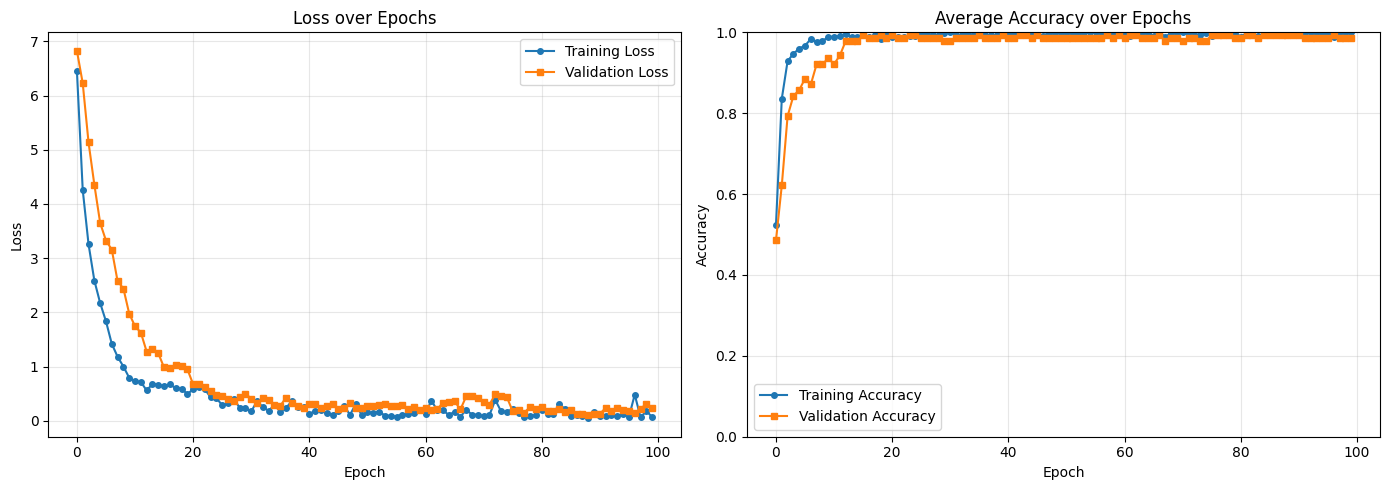

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', marker='o', markersize=4)
axes[0].plot(val_losses, label='Validation Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label='Training Accuracy', marker='o', markersize=4)
axes[1].plot(val_accs, label='Validation Accuracy', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Average Accuracy over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### Calculate Test Accuracy

In [21]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds = {k: [] for k in ['shape', 'color', 'number', 'shading']}
all_labels = {k: [] for k in ['shape', 'color', 'number', 'shading']}

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        
        for key in outputs.keys():
            preds = outputs[key].argmax(dim=1).cpu().numpy()
            all_preds[key].extend(preds)
            all_labels[key].extend(labels[key].numpy())

# Calculate accuracy for each property
print("=" * 50)
print("Validation Accuracy by Property")
print("=" * 50)

for key in ['shape', 'color', 'number', 'shading']:
    acc = accuracy_score(all_labels[key], all_preds[key])
    print(f"{key.capitalize()}: {acc * 100:.2f}%")

# Calculate "perfect card" accuracy (all 4 properties correct)
perfect = sum(
    all(all_preds[k][i] == all_labels[k][i] for k in all_preds.keys())
    for i in range(len(all_labels['shape']))
)
total = len(all_labels['shape'])
print(f"\nPerfect Card Accuracy: {perfect / total * 100:.2f}% ({perfect}/{total})")

Validation Accuracy by Property
Shape: 100.00%
Color: 100.00%
Number: 97.14%
Shading: 97.14%

Perfect Card Accuracy: 94.29% (33/35)


### Confusion Matrices

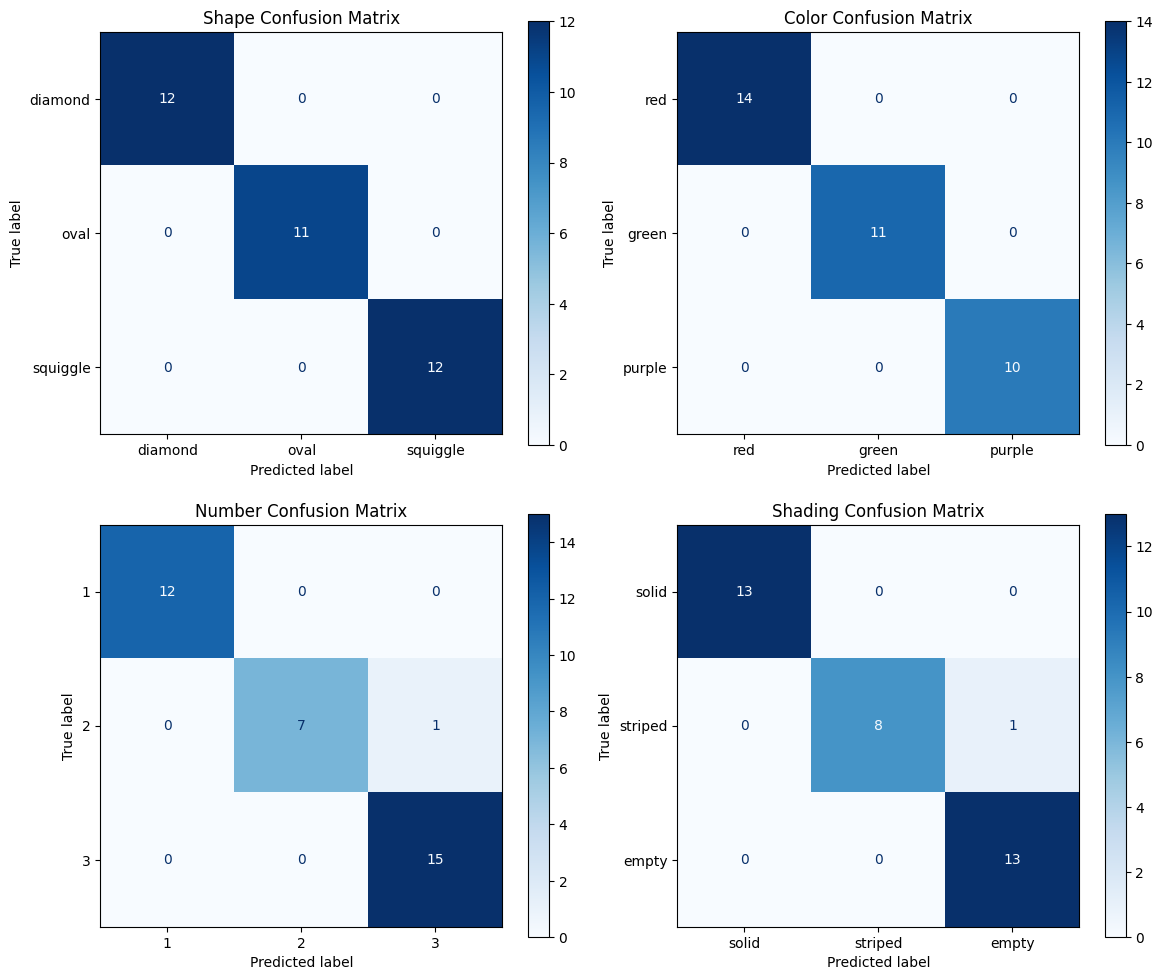

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

property_info = [
    ('shape', SHAPES, axes[0, 0]),
    ('color', COLORS, axes[0, 1]),
    ('number', [str(n) for n in NUMBERS], axes[1, 0]),
    ('shading', SHADINGS, axes[1, 1]),
]

for prop, labels_list, ax in property_info:
    cm = confusion_matrix(all_labels[prop], all_preds[prop])
    disp = ConfusionMatrixDisplay(cm, display_labels=labels_list)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{prop.capitalize()} Confusion Matrix')

plt.tight_layout()
plt.show()

## Model Evaluation on Individual Cards

In [23]:
def preprocess_image(image_path, transform):
    """Load and preprocess an image."""
    image = Image.open(image_path).convert('RGB')
    return image, transform(image).unsqueeze(0)

def predict_card(model, image_tensor, device):
    """Predict card properties."""
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probs = {k: torch.softmax(v, dim=1)[0].cpu().numpy() for k, v in outputs.items()}
        preds = {k: v.argmax(dim=1).item() for k, v in outputs.items()}
    
    return {
        'shape': IDX_TO_SHAPE[preds['shape']],
        'color': IDX_TO_COLOR[preds['color']],
        'number': IDX_TO_NUMBER[preds['number']],
        'shading': IDX_TO_SHADING[preds['shading']],
    }, probs

def visualize_prediction(original_image, preds, probs, ground_truth=None):
    """Visualize prediction with confidence bars."""
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    
    # Display image
    axes[0].imshow(original_image)
    axes[0].axis('off')
    pred_str = f"{preds['number']} {preds['shading']}\n{preds['color']} {preds['shape']}"
    
    if ground_truth:
        gt_str = f"{ground_truth['number']} {ground_truth['shading']}\n{ground_truth['color']} {ground_truth['shape']}"
        correct = all(preds[k] == ground_truth[k] for k in preds.keys())
        axes[0].set_title(f"Pred: {pred_str}\nGT: {gt_str}", 
                          color='green' if correct else 'red', fontsize=10)
    else:
        axes[0].set_title(f"Prediction:\n{pred_str}", fontsize=10)
    
    # Confidence bars for each property
    props = [('shape', SHAPES), ('color', COLORS), ('number', NUMBERS), ('shading', SHADINGS)]
    colors = ['coral', 'lightgreen', 'skyblue', 'plum']
    
    for ax, (prop, labels), color in zip(axes[1:], props, colors):
        labels_str = [str(l) for l in labels]
        ax.barh(labels_str, probs[prop], color=color)
        ax.set_xlim(0, 1)
        ax.set_title(prop.capitalize())
        ax.set_xlabel('Confidence')
    
    plt.tight_layout()
    plt.show()

Loaded 172 samples from ./data


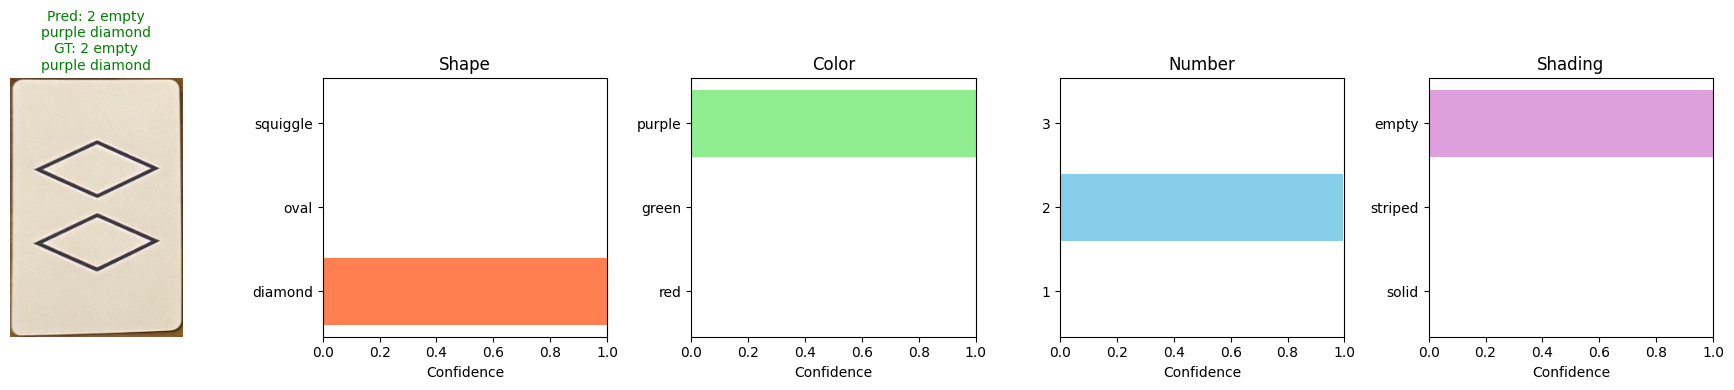

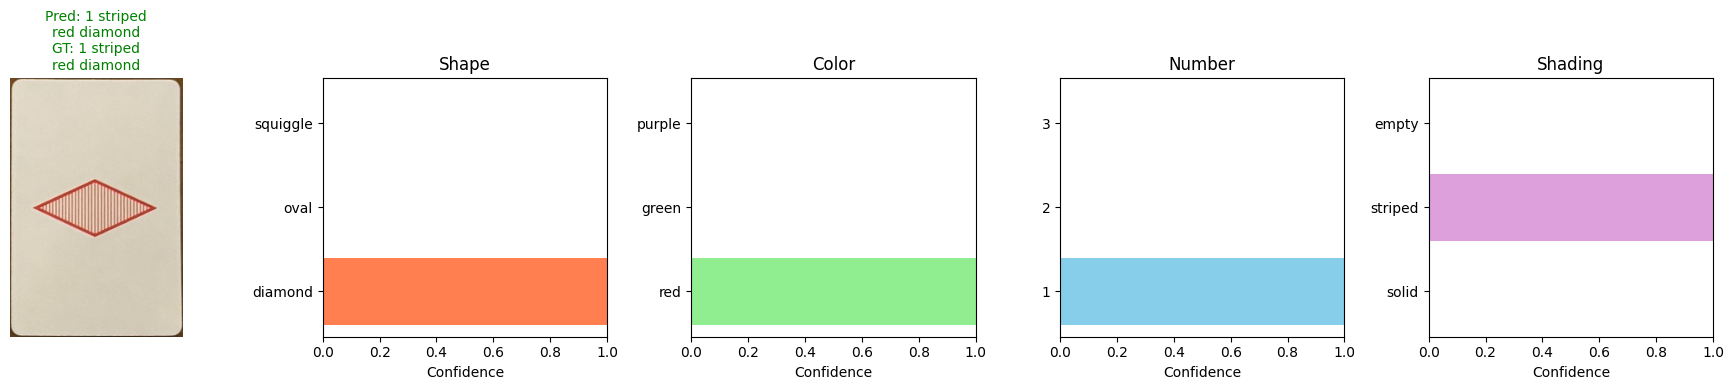

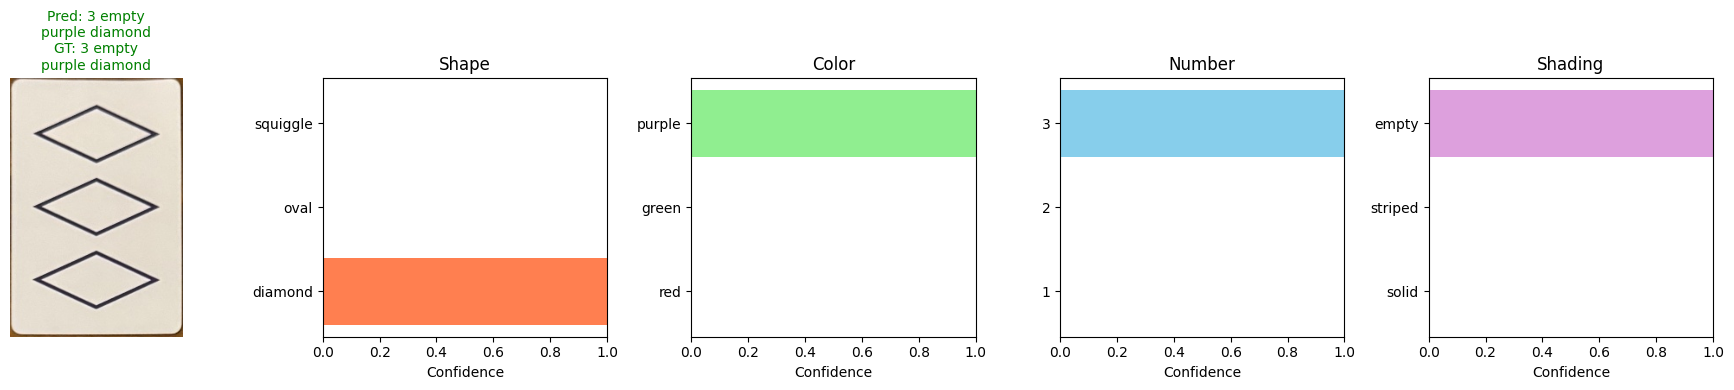

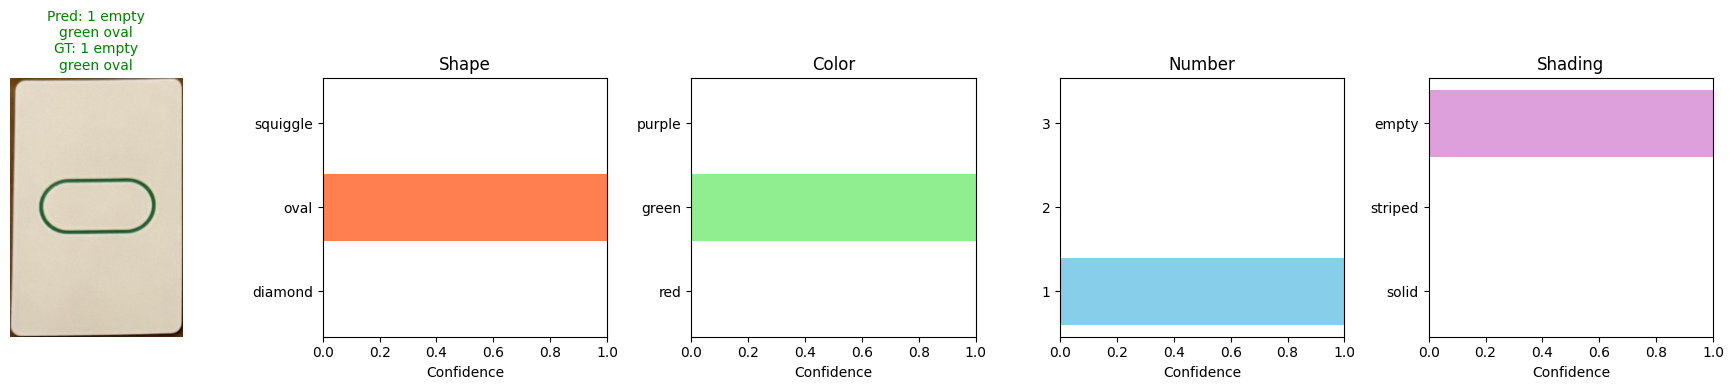

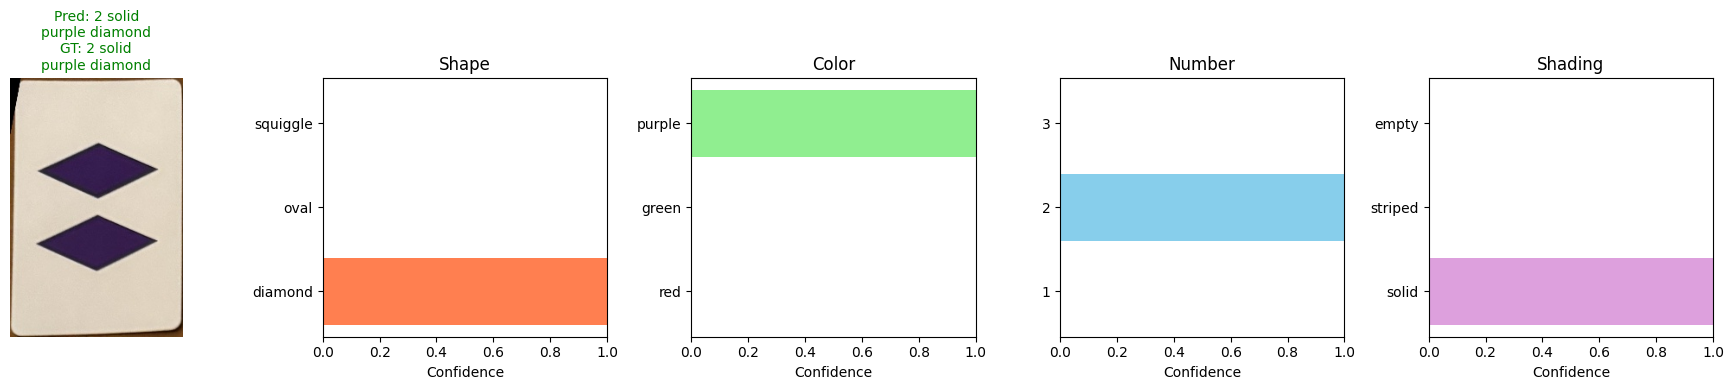

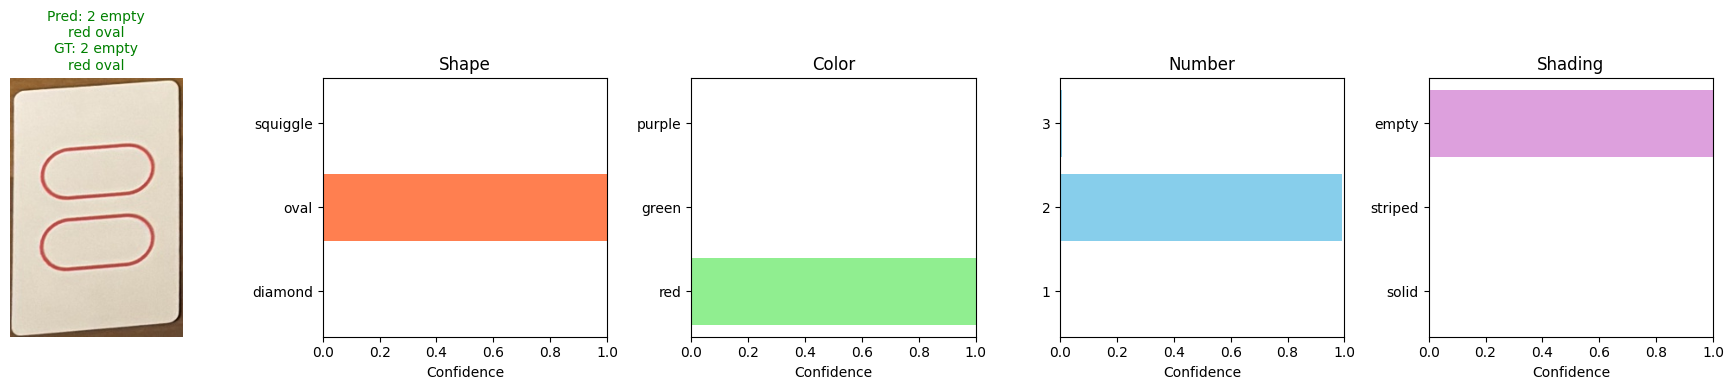

In [24]:
# Test on random validation samples
test_dataset = SetCardDataset(data_dir)  # Without transform for visualization
test_indices = np.random.choice(len(test_dataset), 6, replace=False)

for idx in test_indices:
    image, labels = test_dataset[idx]
    _, image_tensor = preprocess_image(test_dataset.samples[idx][0], val_transform)
    
    preds, probs = predict_card(model, image_tensor, device)
    
    ground_truth = {
        'shape': IDX_TO_SHAPE[labels['shape']],
        'color': IDX_TO_COLOR[labels['color']],
        'number': IDX_TO_NUMBER[labels['number']],
        'shading': IDX_TO_SHADING[labels['shading']],
    }
    
    visualize_prediction(image, preds, probs, ground_truth)

## Save Model

In [25]:
# Save the trained model
output_dir = Path('../outputs/classifier')
output_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
torch.save(model.state_dict(), output_dir / 'best.pt')
print(f"Model saved to {output_dir / 'best.pt'}")

# Save full checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
}, output_dir / 'checkpoint.pt')
print(f"Checkpoint saved to {output_dir / 'checkpoint.pt'}")

Model saved to ../outputs/classifier/best.pt
Checkpoint saved to ../outputs/classifier/checkpoint.pt


## Export to ONNX for Web App

Export the trained model to ONNX format for use in the web application.

In [26]:
# Export to ONNX for web deployment
import torch.onnx

# Wrapper class to convert dict output to tuple for ONNX
class ClassifierWrapper(nn.Module):
    """Wrapper to convert dict output to named outputs for ONNX export."""
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        out = self.model(x)
        return out['shape'], out['color'], out['number'], out['shading']

# Create wrapped model
model.eval()
model.cpu()  # Export on CPU
wrapped_model = ClassifierWrapper(model)

# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224)

# Export paths
onnx_output_dir = Path('../public/models')
onnx_output_dir.mkdir(parents=True, exist_ok=True)
onnx_path = onnx_output_dir / 'classifier.onnx'

# Export to ONNX using legacy exporter (more compatible)
torch.onnx.export(
    wrapped_model,
    dummy_input,
    str(onnx_path),
    export_params=True,
    opset_version=14,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['shape', 'color', 'number', 'shading'],
    dynamo=False,  # Use legacy exporter for compatibility
)

print(f"✅ Model exported to: {onnx_path.absolute()}")
print(f"   Size: {onnx_path.stat().st_size / 1024 / 1024:.2f} MB")

# Move model back to device for further use
model.to(device)
print(f"\nModel ready for web app at: /models/classifier.onnx")

/var/folders/k9/bbqmp2v55bzf74dt8gqxb3zm0000gn/T/ipykernel_45414/3778959459.py:29: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ Model exported to: /Users/gabrielpascualy/Documents/setsolver/ml/notebooks/../public/models/classifier.onnx
   Size: 4.99 MB

Model ready for web app at: web/public/models/classifier.onnx


In [27]:
# Verify ONNX export
try:
    import onnxruntime as ort
    
    print("Verifying ONNX export...")
    session = ort.InferenceSession(str(onnx_path))
    
    # Get input/output details
    input_name = session.get_inputs()[0].name
    output_names = [o.name for o in session.get_outputs()]
    
    print(f"  Input: {input_name} {session.get_inputs()[0].shape}")
    print(f"  Outputs: {output_names}")
    
    # Test inference
    test_input = np.random.randn(1, 3, 224, 224).astype(np.float32)
    outputs = session.run(None, {input_name: test_input})
    
    print(f"\n✅ ONNX model verified!")
    print(f"  Output shapes: {[o.shape for o in outputs]}")
    
except ImportError:
    print("⚠️  Install onnxruntime to verify: pip install onnxruntime")
except Exception as e:
    print(f"❌ ONNX verification failed: {e}")

⚠️  Install onnxruntime to verify: pip install onnxruntime


## Next Steps

1. **Export to ONNX** for web deployment:
   ```bash
   python scripts/export_models.py --classifier outputs/classifier/best.pt
   ```

2. **Test on real images** from a camera

3. **Improve accuracy** by:
   - Collecting more training data
   - Stronger augmentation
   - Fine-tuning hyperparameters
   - Using a larger backbone (EfficientNet)